## Iris Classification

import all necesarry libraries

In [56]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import math
from collections import Counter

from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.stats import sem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.12.1
pandas version: 0.20.1
scikit-learn version: 0.18.1
matplotlib version: 2.0.2


Make my own classifier

In [70]:

class ClosestNeighborClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, k):
         self.k = k

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self
    
    def distance(self, instance1, instance2):
        # just in case, if the instances are lists or tuples:
        instance1 = np.array(instance1) 
        instance2 = np.array(instance2)

        return np.linalg.norm(instance1 - instance2)
    
    def get_neighbors(self, training_set, labels, test_instance, k):
        distances = []
        for t, l in zip(training_set, labels):
            dist = self.distance(test_instance, t)
            distances.append([tuple(t), dist, l])
        distances.sort(key=lambda x: abs(x[1]))
        return distances[:k]

    def vote(self, neighbors):
        class_counter = Counter()
        for neighbor in neighbors:
            class_counter[neighbor[2]] += 1
        return class_counter.most_common(1)[0][0]

    def predict(self, X):        
        results = []
        for x in X:
            neighbors = self.get_neighbors(self.X_, self.y_, x, self.k)
            results.append(self.vote(neighbors))
            
        return results

Reading iris dataframe

In [71]:
datafolder = 'data/'
filename = 'iris.data.csv'
iris = pd.read_csv(datafolder + filename, sep=',', low_memory=False, encoding = 'ISO-8859-1')
print(iris.shape)
iris.head()

(149, 5)


,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In the output above can be seen that there are no proper headers, this we have to add them

In [72]:
iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


map species types to numbers to allow us to analyse it

In [73]:
iris['Label'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica':2})
iris.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species,Label
0,4.9,3.0,1.4,0.2,Iris-setosa,0
1,4.7,3.2,1.3,0.2,Iris-setosa,0
2,4.6,3.1,1.5,0.2,Iris-setosa,0
3,5.0,3.6,1.4,0.2,Iris-setosa,0
4,5.4,3.9,1.7,0.4,Iris-setosa,0


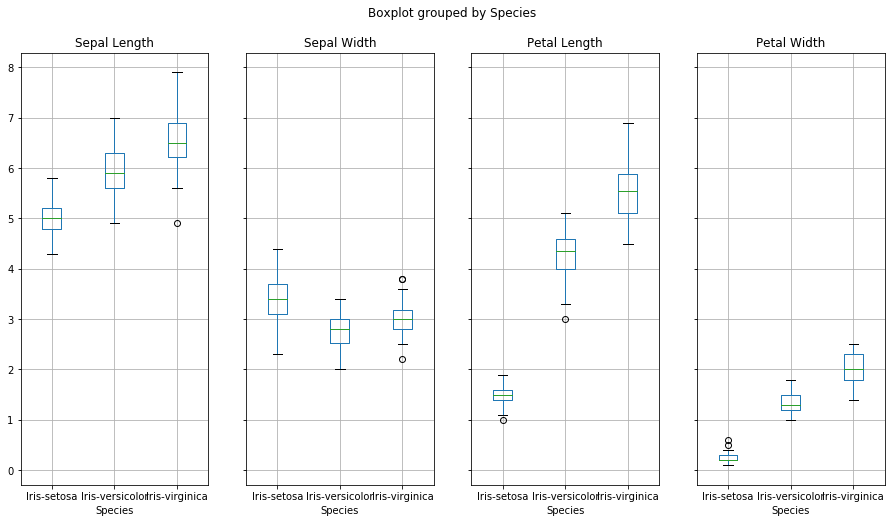

In [74]:
features = tuple(iris.columns[:4].values)
iris.boxplot(column=features, by='Species', figsize=(15,8), layout=(1,4));

In [75]:
# Get from the dataframe only the first two features, it is common practice to call this X (the independent variables)
X = iris[['Petal Length','Petal Width']] 

# Get from the dataframe the just created label variable, usually called y (the target class that you want to predict)
y = iris['Label']

# Standarize the features
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [76]:
# Split the dataset into a training and a testing set; test set will be the 25% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
print(X_train.shape, y_train.shape)

(111, 2) (111,)


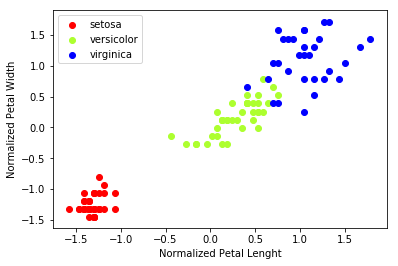

In [77]:
colors = ('red', 'greenyellow', 'blue')
for i in range(len(colors)):
    x1s = X_train[:, 0][y_train.as_matrix() == i]
    x2s = X_train[:, 1][y_train.as_matrix() == i]
    plt.scatter(x1s, x2s, c=colors[i])

plt.legend(['setosa', 'versicolor', 'virginica'])   # maintain order from dataset preparation
plt.xlabel('Normalized Petal Lenght')
plt.ylabel('Normalized Petal Width')

In [78]:
clf = ClosestNeighborClassifier(k=5)

# Fit (= train) the classifier
clf.fit(X_train, y_train)


ClosestNeighborClassifier(k=5)

In [81]:
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.94736842105263153

In [80]:
def evaluate_cross_validation(clf, X, y, K):
    # Create a k-fold cross validation iterator
    kf = KFold(K, shuffle=True, random_state=0)
    
    # By default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=kf)
    
    # scores = cross_val_score(clf, X, y, cv=K)     # This also works directly, without KFold function!
    
    print(scores)
    print(("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))
    
evaluate_cross_validation(clf, X_train, y_train, 5)

[ 1.          0.95454545  0.95454545  0.95454545  0.95454545]
Mean score: 0.964 (+/-0.009)
